Ce notebook a pour objectifs de choisir l'algorithme qui sera utilisé plus tard.

# Modèle de prédiction de la gravité des accidents par année :

## Année 2005 : 

#### Required libraries :

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#load data
data2005=pd.read_csv('data1.csv',encoding='latin-1')
# let's first create an attribute age :
data2005.loc[:,['an']]=data2005.loc[:,['an']]+2000
data2005['age']=pd.Series(data2005.an.values - data2005.an_nais.values)
#choose features to use for classification  : 
#( we delete all spatiale features: lon/lat/dep/com/addresse/agg/voie/v1/v2 ..)
# we delete an/mois/jours ( later we will do feature engineering to creata a variable for the number of the day in the week 
#to see the effet of weekend ...)
col_used =['lum','int', 'atm', 'col', 'catr', 'circ', 'vosp', 'prof', 'plan', 'surf', 'infra', 'situ', 'senc', 'catv',
       'obs', 'obsm', 'choc', 'manv', 'place', 'catu',
       'grav', 'sexe', 'trajet', 'secu', 'locp', 'actp', 'etatp', 
       'age']
data2005=data2005.loc[:,col_used]

Avant d'effectuer l'apprentissage, nous devons passer par une étape très importante : le codage des variable.

En effet, dans notre trame de donnée on dispose soit des variable numériques ( age, pr1, ..) soit des variable nominales ( lum, int, ..). Donc le fait de laisser les variables nominale codées en entier sera interprété par les algorithmes comme étant des variables ordinales ou numériques. Pour éviter ce genre de problème on va effectuer ce qu'on appele le One-Hot Encoding en utilisant la fonction get_dummies. Mais avant d'appliquer cette méthode, il faut spécifier que ces variables sont bien nominale via le changement de type de (float,int) vers (object).

In [3]:
#change types :
for col in col_used :
    data2005[col]=data2005[col].astype(str)

data2005.age=data2005.age.astype(float) # age is a numeric not string
# split data into target and feature data :
y=data2005.grav.values  # target column
X=data2005.loc[:,data2005.columns!='grav']  # feature data
#get dummies for feature data :
X=pd.get_dummies(X,prefix_sep='_')

Il reste une seule étape et c'est fini, c'est la normalisation de la variable age. En effet, la normalisation va consister à prendre le logarithme de la variable en question. Ceci est importante dans la mesure  ou toutes les variables sont binaire sauf l'âge.

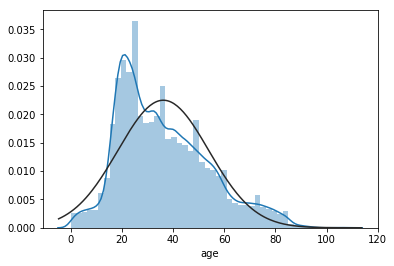

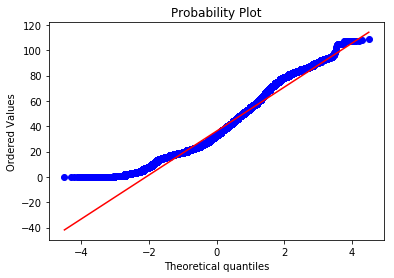

In [4]:
from scipy.stats import norm
from scipy import stats
#histogram and normal probability plot
sns.distplot(X['age'], fit=norm);
fig = plt.figure()
res = stats.probplot(X['age'], plot=plt)
plt.show()

Dans ce cas, l'âge  a une variance numérique élevée, et par conséquent on applique le  logarithme sur cette variable. 

In [5]:
X['age'] = np.log1p(X['age'])

Maintenant les données sont prêtes pour être modélisées :

### 1. Sélection des variables en utilisant RandomForest :

#### 1.1 Avec codage des variable catégorielles :

On a chercher les variables importantes en utilisant le codage des variables catégorielles :

In [6]:
#required  libraries :
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
#split data into train/test data :
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size = 0.3,random_state = 1)
rf = RandomForestClassifier(random_state = 4,n_jobs=-1,n_estimators=20)
#fit model
rf.fit(x_train,y_train)
#predict on unseen data :
y_pred = rf.predict(x_test)
cm = confusion_matrix(y_test,y_pred)
print('Confusion matrix: \n',cm)
print('Classification report: \n',classification_report(y_test,y_pred))
for  importance,name in sorted(list(zip( rf.feature_importances_,list(X.columns))),reverse=True):
    print(name, "=", importance)

Confusion matrix: 
 [[19501    49  1149  3505]
 [  277   116   822   416]
 [ 2301   201  4375  5234]
 [ 5694    92  3757 11760]]
Classification report: 
              precision    recall  f1-score   support

          1       0.70      0.81      0.75     24204
          2       0.25      0.07      0.11      1631
          3       0.43      0.36      0.39     12111
          4       0.56      0.55      0.56     21303

avg / total       0.58      0.60      0.59     59249

age = 0.134334304369
secu_21.0 = 0.0239526405082
secu_11.0 = 0.0199263897392
catu_1 = 0.0170581802835
manv_1.0 = 0.015953690675
obs_0.0 = 0.0158575080556
lum_1 = 0.0154691457333
choc_1.0 = 0.0153450426715
catv_7 = 0.0148444594594
trajet_5.0 = 0.0140507133362
obsm_1.0 = 0.0129991643219
catr_4.0 = 0.0129267521506
prof_1.0 = 0.0127712862962
trajet_9.0 = 0.0123288649091
catv_5 = 0.0120894226134
catr_3.0 = 0.0119218407706
int_1 = 0.0116782745329
circ_2.0 = 0.0111597720933
sexe_2 = 0.0110213288702
prof_2.0 = 0.0110121676984
l

voyons maintenant l'importance des variables par ordre décroissant :

L'age, secu, catu, manv,obs, lum, choc,catv,trajet,obsm,catr,prof, catv,int, circ et sexe sont des  variables importantes (on peut ajouter d'autres mais ces variables sont déjà bonnes). 

Pour justifier, on va élaborer un modèle en utilisant que ces variables puis on comparera les performance :

In [7]:
#load data
data2005=pd.read_csv('data1.csv',encoding='latin-1')
# let's first create an attribute age :
data2005.loc[:,['an']]=data2005.loc[:,['an']]+2000
data2005['age']=pd.Series(data2005.an.values - data2005.an_nais.values)
#choose features to use for classification  : 
#( we delete all spatiale features: lon/lat/dep/com/addresse/agg/voie/v1/v2 ..)
# we delete an/mois/jours ( later we will do feature engineering to creata a variable for the number of the day in the week 
#to see the effet of weekend ...)
col_used =['lum','int', 'catr', 'circ', 'prof', 'catv',
       'obs',  'choc','obsm' ,'manv',  'catu',
       'grav', 'sexe', 'trajet', 'secu', 'age']
data2005=data2005.loc[:,col_used]
#change types :
for col in col_used :
    data2005[col]=data2005[col].astype(str)

data2005.age=data2005.age.astype(float)
# split data into target and feature data :
y=data2005.grav.values  # target column
X=data2005.loc[:,data2005.columns!='grav']  # feature data
X['age'] = np.log1p(X['age']) # normalize age
#get dummies for feature data :
X=pd.get_dummies(X,prefix_sep='_')

C:\Users\rlouriz\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [8]:
#required  libraries :
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
#split data into train/test data :
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size = 0.3,random_state = 1)
rf = RandomForestClassifier(random_state = 4,n_jobs=-1,n_estimators=20)
#fit model
rf.fit(x_train,y_train)
#predict on unseen data :
y_pred = rf.predict(x_test)
cm = confusion_matrix(y_test,y_pred)
print('Confusion matrix: \n',cm)
print('Classification report: \n',classification_report(y_test,y_pred))
for  importance,name in sorted(list(zip( rf.feature_importances_,list(X.columns))),reverse=True):
    print(name, "=", importance)


Confusion matrix: 
 [[18696   104  1372  4032]
 [  249   152   793   437]
 [ 2339   298  4276  5198]
 [ 5678   200  4094 11331]]
Classification report: 
              precision    recall  f1-score   support

          1       0.69      0.77      0.73     24204
          2       0.20      0.09      0.13      1631
          3       0.41      0.35      0.38     12111
          4       0.54      0.53      0.54     21303

avg / total       0.57      0.58      0.57     59249

age = 0.247226269926
catu_1 = 0.0258769350989
secu_21.0 = 0.0204218026875
obs_0.0 = 0.0203147136109
catu_3 = 0.0196172604722
manv_1.0 = 0.0192182916351
secu_11.0 = 0.0187145434981
catv_7 = 0.0182713431847
choc_1.0 = 0.0166629178029
lum_1 = 0.0163784839572
obsm_1.0 = 0.0159815482044
prof_1.0 = 0.0150153343188
catr_4.0 = 0.0142909497522
trajet_5.0 = 0.0141893274334
trajet_9.0 = 0.0137728426237
int_1 = 0.013768105886
catv_5 = 0.0135794331643
catr_3.0 = 0.0132170436416
prof_2.0 = 0.0131449687405
circ_2.0 = 0.0129640364947
l

Toujours l'âge est en tête de la liste.

 Parfait les résultats sont quasiment les mêmes avec quelques diminution pour les modalités ( indemne et tué) et quelques améliorations pour les autres modalitées ( blessé léger/hospitalisé).

Rq: la condition atmosphériques n'influe pas la gravité des accidents. Ceci peut être expliqué par le fait que si le climat n'est pas bon, il y a peu de monde qui sont motivés pour conduire  et donc dimunie le trafic et par conséquent les accidents.

#### 1.2 Sans codage des variable catégorielles :

On a chercher les variables importantes sans utiliser le codage des variables catégorielles :

In [10]:
#load data
data2005=pd.read_csv('data1.csv',encoding='latin-1')
# let's first create an attribute age :
data2005.loc[:,['an']]=data2005.loc[:,['an']]+2000
data2005['age']=pd.Series(data2005.an.values - data2005.an_nais.values)
#choose features to use for classification  : 
#( we delete all spatiale features: lon/lat/dep/com/addresse/agg/voie/v1/v2 ..)
# we delete an/mois/jours ( later we will do feature engineering to creata a variable for the number of the day in the week 
#to see the effet of weekend ...)

col_used =['lum','int', 'atm', 'col', 'catr', 'circ', 'vosp', 'prof', 'plan', 'surf', 'infra', 'situ', 'senc', 'catv',
       'obs', 'obsm', 'choc', 'manv', 'place', 'catu',
       'grav', 'sexe', 'trajet', 'secu', 'locp', 'actp', 'etatp', 
       'age']

data2005=data2005.loc[:,col_used]

#change types :
for col in col_used :
    data2005[col]=data2005[col].astype(str)
data2005.age=data2005.age.astype(float)

# split data into target and feature data :
y=data2005.grav.values  # target column
X=data2005.loc[:,data2005.columns!='grav']  # feature data

X['age'] = np.log1p(X['age']) # normalize age

C:\Users\rlouriz\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [11]:
#required  libraries :
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
#split data into train/test data :
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size = 0.3,random_state = 1)
rf = RandomForestClassifier(random_state = 4,n_jobs=-1,n_estimators=20)
#fit model
rf.fit(x_train,y_train)
#predict on unseen data :
y_pred = rf.predict(x_test)
cm = confusion_matrix(y_test,y_pred)
print('Confusion matrix: \n',cm)
print('Classification report: \n',classification_report(y_test,y_pred))
for  importance,name in sorted(list(zip( rf.feature_importances_,list(X.columns))),reverse=True):
    print(name, "=", importance)

Confusion matrix: 
 [[19534    44  1059  3567]
 [  268   121   800   442]
 [ 2265   196  4478  5172]
 [ 5735    77  3843 11648]]
Classification report: 
              precision    recall  f1-score   support

          1       0.70      0.81      0.75     24204
          2       0.28      0.07      0.12      1631
          3       0.44      0.37      0.40     12111
          4       0.56      0.55      0.55     21303

avg / total       0.59      0.60      0.59     59249

age = 0.179075484821
catv = 0.0868843858879
manv = 0.0715285459199
choc = 0.0582300630943
col = 0.0537165914648
secu = 0.0468587064404
catr = 0.0441793863598
trajet = 0.0421973193249
obsm = 0.038374227494
obs = 0.0376803612264
lum = 0.036406729712
int = 0.0349242030718
circ = 0.0276351720882
atm = 0.0274859142637
prof = 0.0274366547812
plan = 0.0251772052819
surf = 0.0235926258383
catu = 0.0223828979912
place = 0.0202016303455
infra = 0.0196696581072
sexe = 0.0181417919637
etatp = 0.0158034489939
actp = 0.0121485533999


On remarque que même sans codage des variables catégorielles on obtient de bonnes résultats avec une légére différence au niveau des importances des variables. Mais il faut faire attention car ceci parfois n'est pas optimale.

En appliquant randomforest avec les variables les plus importantes et toujours sans codage des variables :

In [12]:
#load data
data2005=pd.read_csv('data1.csv',encoding='latin-1')
# let's first create an attribute age :
data2005.loc[:,['an']]=data2005.loc[:,['an']]+2000
data2005['age']=pd.Series(data2005.an.values - data2005.an_nais.values)
#choose features to use for classification  : 
#( we delete all spatiale features: lon/lat/dep/com/addresse/agg/voie/v1/v2 ..)
# we delete an/mois/jours ( later we will do feature engineering to creata a variable for the number of the day in the week 
#to see the effet of weekend ...)

col_used =['lum','int', 'catr', 'circ', 'prof', 'catv',
       'obs',  'choc','obsm' ,'manv',  'catu','col',
       'grav', 'sexe', 'trajet', 'secu', 'age']

data2005=data2005.loc[:,col_used]

#change types :
for col in col_used :
    data2005[col]=data2005[col].astype(str)
data2005.age=data2005.age.astype(float)

# split data into target and feature data :
y=data2005.grav.values  # target column
X=data2005.loc[:,data2005.columns!='grav']  # feature data

X['age'] = np.log1p(X['age']) # normalize age
#required  libraries :
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
#split data into train/test data :
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size = 0.3,random_state = 1)
rf = RandomForestClassifier(random_state = 4,n_jobs=-1,n_estimators=20)
#fit model
rf.fit(x_train,y_train)
#predict on unseen data :
y_pred = rf.predict(x_test)
cm = confusion_matrix(y_test,y_pred)
print('Confusion matrix: \n',cm)
print('Classification report: \n',classification_report(y_test,y_pred))
for  importance,name in sorted(list(zip( rf.feature_importances_,list(X.columns))),reverse=True):
    print(name, "=", importance)

C:\Users\rlouriz\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Confusion matrix: 
 [[19205    76  1220  3703]
 [  263   143   773   452]
 [ 2243   265  4313  5290]
 [ 5621   158  4023 11501]]
Classification report: 
              precision    recall  f1-score   support

          1       0.70      0.79      0.75     24204
          2       0.22      0.09      0.13      1631
          3       0.42      0.36      0.38     12111
          4       0.55      0.54      0.54     21303

avg / total       0.58      0.59      0.58     59249

age = 0.237073384445
manv = 0.0870261913304
catv = 0.076421220053
choc = 0.0668144519297
col = 0.0603659452245
catu = 0.0589793585541
secu = 0.0584824404928
catr = 0.0489562624074
trajet = 0.0484250919431
lum = 0.0442471100546
obsm = 0.041659727535
int = 0.0409407054428
obs = 0.0409397413311
prof = 0.0340319750344
circ = 0.0337136447068
sexe = 0.0219227495152


Les résultats sont toujours quasiment proches en utilisant peu de variables.

##### Arbre de décision pour une bonne visualisation des résultats : 

In [ ]:
#load data
data2005=pd.read_csv('data1.csv',encoding='latin-1')
# let's first create an attribute age :
data2005.loc[:,['an']]=data2005.loc[:,['an']]+2000
data2005['age']=pd.Series(data2005.an.values - data2005.an_nais.values)
#choose features to use for classification  : 
#( we delete all spatiale features: lon/lat/dep/com/addresse/agg/voie/v1/v2 ..)
# we delete an/mois/jours ( later we will do feature engineering to creata a variable for the number of the day in the week 
#to see the effet of weekend ...)

col_used =['lum','int', 'atm', 'col', 'catr', 'circ', 'vosp', 'prof', 'plan', 'surf', 'infra', 'situ', 'senc', 'catv',
       'obs', 'obsm', 'choc', 'manv', 'place', 'catu',
       'grav', 'sexe', 'trajet', 'secu', 'locp', 'actp', 'etatp', 
       'age']
data2005=data2005.loc[:,col_used]

#change types :
for col in col_used :
    data2005[col]=data2005[col].astype(str)
data2005.age=data2005.age.astype(float)

# split data into target and feature data :
y=data2005.grav.values  # target column
X=data2005.loc[:,data2005.columns!='grav']  # feature data

X['age'] = np.log1p(X['age']) # normalize age
#required  libraries :
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
#split data into train/test data :
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size = 0.3,random_state = 1)
dt = DecisionTreeClassifier(random_state = 4,max_depth=6)
#fit model
dt.fit(x_train,y_train)
#predict on unseen data :
y_pred = dt.predict(x_test)
cm = confusion_matrix(y_test,y_pred)
print('Confusion matrix: \n',cm)
print('Classification report: \n',classification_report(y_test,y_pred))
for  importance,name in sorted(list(zip( dt.feature_importances_,list(X.columns))),reverse=True):
    print(name, "=", importance)

In [14]:
# see the tree for our decision tree classification model :
# to see the tree visit link : webgraphviz.com   then copy and paste the contente of tree.txt in the cell given 
from sklearn import tree
tree.export_graphviz(dt,out_file="tree.txt",impurity = True,
                            feature_names = list(X.columns),
                            class_names = ['Indemne', 'Tué','BlesseHospitalisé','Blesséléger'],
                            rounded = True,
                            filled= True )

### 2. Sélection des variables en utilisant Gradient Boosting:

Cette partie a pour but de confirmer la séléction des variable en utilisant l'algorithme GB

Un avantage de l'utilisation <b>Gradient Boosing</b> est que, après la construction des arbres boostés, il est relativement simple de récupérer des scores d'importance pour chaque variables (feature).


Généralement, l'importance fournit un score qui indique l'utilité de chaque variable dans la construction des arbres de décision boostés dans le modèle. Plus un attribut est utilisé pour prendre des décisions clés avec des arbres de décision, plus son importance relative est élevée.


Cette importance est calculée explicitement pour chaque attribut de l'ensemble de données, ce qui permet de classer et de comparer les attributs les uns par rapport aux autres.


L'importance est calculée pour un arbre de décision unique en fonction du fait que chaque point de partage d'attribut améliore la mesure de la performance, pondérée par le nombre d'observations dont le noeud est responsable. La mesure de performance peut être la pureté (indice de Gini) utilisée pour sélectionner les points de partage ou une autre fonction d'erreur plus spécifique.


<mark>Les importances des variables sont ensuite moyennées à partir de tous les arbres de décision du modèle.</mark>


source: https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/

C:\Users\rlouriz\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Confsuion matrix : 
  [[20798     0   461  2945]
 [  396    12   724   499]
 [ 2911     5  2751  6444]
 [ 6839     4  1860 12600]]
Classification report : 
               precision    recall  f1-score   support

          1       0.67      0.86      0.75     24204
          2       0.57      0.01      0.01      1631
          3       0.47      0.23      0.31     12111
          4       0.56      0.59      0.58     21303

avg / total       0.59      0.61      0.58     59249



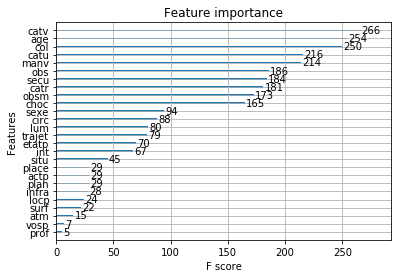

In [5]:
#load data: later we will let the original data without imputing missing data because XGboost can deal with them
data2005=pd.read_csv('data1.csv',encoding='latin-1')
# let's first create an attribute age :
data2005.loc[:,['an']]=data2005.loc[:,['an']]+2000
data2005['age']=pd.Series(data2005.an.values - data2005.an_nais.values)
#choose features to use for classification  : 
#( we delete all spatiale features: lon/lat/dep/com/addresse/agg/voie/v1/v2 ..)
# we delete an/mois/jours ( later we will do feature engineering to creata a variable for the number of the day in the week 
#to see the effet of weekend ...)

col_used =['lum','int', 'atm', 'col', 'catr', 'circ', 'vosp', 'prof', 'plan', 'surf', 'infra', 'situ', 'senc', 'catv',
       'obs', 'obsm', 'choc', 'manv', 'place', 'catu',
       'grav', 'sexe', 'trajet', 'secu', 'locp', 'actp', 'etatp', 
       'age']
data2005=data2005.loc[:,col_used]

#DataFrame.dtypes for data must be int, float or bool. So we do not perform any changing for dtypes

# split data into target and feature data :
y=data2005.grav.values  # target column
X=data2005.loc[:,data2005.columns!='grav']  # feature data

X['age'] = np.log1p(X['age']) # normalize age
#required  libraries :
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from xgboost import plot_importance
#split data into train/test data :

xgboost_model=XGBClassifier()
#fit model on training set
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=1)
xgboost_model.fit(X_train,y_train)
#predict on test set :
y_pred=xgboost_model.predict(X_test)
cm=confusion_matrix(y_test,y_pred)
print("Confsuion matrix : \n ",cm)
print('Classification report : \n ',classification_report(y_test,y_pred))
# plot feature importance : The XGBoost library provides a built-in function to plot features ordered by their importance.
plot_importance(xgboost_model)
plt.show()

Comme vous le constatez on obtient des résultats très intérressants au niveau des performances. En ce qui concerne Les importances des variables, on voit que les résultats sont  quasiment similaires à ceux déjà trouvé à l'aide des forêts aléatoires (RandomForest). Plus précisement : 

    1. catv, age, col et catu sont les plus importants variables dans notre jeu de données
    2. atm, vosp et prof sont les variables avec les plus petites importances.
    
Nos dires en ce qui concerne le climat sont confirmés une autre fois.

#### Sélection des variables nécessaire pour l'apprentissage en utilisant les importances ci-dessis :

Les scores d'importance  peuvent être utilisés pour la sélection des variables.

Ceci est fait en utilisant la classe <b>SelectFromModel</b> qui prend un modèle et peut transformer un ensemble de données en un sous-ensemble avec les caractéristiques sélectionnées.

Cette classe peut prendre un modèle pré-formé, tel qu'un modèle formé sur l'ensemble de données d'entraînement. Il peut ensuite utiliser un seuil pour décider quelles variables sélectionner. Ce seuil est utilisé lorsque vous appelez la méthode <b>transform ()</b> sur l'instance <b>SelectFromModel</b> pour sélectionner systématiquement les mêmes entités sur l'ensemble de données d'apprentissage et l'ensemble de données de test.

Dans l'exemple ci-dessous, nous formons puis évaluons un modèle XGBoost sur l'ensemble du jeu de données d'apprentissage et des jeux de données de test, respectivement.

En utilisant les importances  calculées à partir du jeu de données d'apprentissage, nous enveloppons ensuite le modèle dans une instance SelectFromModel. Nous l'utilisons pour sélectionner des entités sur l'ensemble de données d'apprentissage, former un modèle à partir du sous-ensemble de caractéristiques sélectionné, puis évaluer le modèle sur l'ensemble de tests, sous réserve du même schéma de sélection d'entités. 

source : https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/

In [6]:
#load data: later we will let the original data without imputing missing data because XGboost can deal with them
data2005=pd.read_csv('data1.csv',encoding='latin-1')
# let's first create an attribute age :
data2005.loc[:,['an']]=data2005.loc[:,['an']]+2000
data2005['age']=pd.Series(data2005.an.values - data2005.an_nais.values)
#choose features to use for classification  : 
#( we delete all spatiale features: lon/lat/dep/com/addresse/agg/voie/v1/v2 ..)
# we delete an/mois/jours ( later we will do feature engineering to creata a variable for the number of the day in the week 
#to see the effet of weekend ...)

col_used =['lum','int', 'atm', 'col', 'catr', 'circ', 'vosp', 'prof', 'plan', 'surf', 'infra', 'situ', 'senc', 'catv',
       'obs', 'obsm', 'choc', 'manv', 'place', 'catu',
       'grav', 'sexe', 'trajet', 'secu', 'locp', 'actp', 'etatp', 
       'age']
data2005=data2005.loc[:,col_used]

#DataFrame.dtypes for data must be int, float or bool. So we do not perform any changing for dtypes

# split data into target and feature data :
y=data2005.grav.values  # target column
X=data2005.loc[:,data2005.columns!='grav']  # feature data

X['age'] = np.log1p(X['age']) # normalize age
#required  libraries :
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from xgboost import plot_importance
from numpy import sort
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel
#split data into train/test data :

xgboost_model=XGBClassifier()
#fit model on training set
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=1)
xgboost_model.fit(X_train,y_train)
#predict on test set :
y_pred=xgboost_model.predict(X_test)
cm=confusion_matrix(y_test,y_pred)
print("Confsuion matrix : \n ",cm)
print('Classification report : \n ',classification_report(y_test,y_pred))
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))


# Fit model using each importance as a threshold
thresholds = sort(xgboost_model.feature_importances_)
for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(xgboost_model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    # train model
    selection_model = XGBClassifier()
    selection_model.fit(select_X_train, y_train)
    # eval model
    select_X_test = selection.transform(X_test)
    y_pred = selection_model.predict(select_X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))


C:\Users\rlouriz\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Confsuion matrix : 
  [[20798     0   461  2945]
 [  396    12   724   499]
 [ 2911     5  2751  6444]
 [ 6839     4  1860 12600]]
Classification report : 
               precision    recall  f1-score   support

          1       0.67      0.86      0.75     24204
          2       0.57      0.01      0.01      1631
          3       0.47      0.23      0.31     12111
          4       0.56      0.59      0.58     21303

avg / total       0.59      0.61      0.58     59249

Accuracy: 61.03%
Thresh=0.000, n=27, Accuracy: 61.03%
Thresh=0.002, n=26, Accuracy: 61.03%
Thresh=0.002, n=25, Accuracy: 61.06%
Thresh=0.005, n=24, Accuracy: 61.05%
Thresh=0.008, n=23, Accuracy: 61.03%
Thresh=0.009, n=22, Accuracy: 61.05%
Thresh=0.010, n=21, Accuracy: 61.10%
Thresh=0.010, n=20, Accuracy: 61.05%
Thresh=0.010, n=20, Accuracy: 61.05%
Thresh=0.010, n=20, Accuracy: 61.05%
Thresh=0.016, n=17, Accuracy: 61.01%
Thresh=0.024, n=16, Accuracy: 60.96%
Thresh=0.025, n=15, Accuracy: 60.98%
Thresh=0.028, n=14, Acc

C'est  claire et évident que les peroformance diminuent avec n le nombre de variables choisies pour effectuer l'apprentissage. Mais déjà on peut se contenter de choisir que 17 variables  et accepter un tel modèle  avec une décroissance de l'accuracy de 61.03% à 61.01%. 

C'est très intérressant surtout quand le jeu de données présentent beaucoup de variables.

#### Avant de confirmer la méthode, on teste les performances de cette méthode sans notre imputation des valeurs manquantes; on laisse les valeurs manquantes pour qu'elles soient traitées par xgboost lui même : 

Le notebook générant les données sans imputation est intitulé : data_cleaning_without_imputing.ipynb

C:\Users\rlouriz\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Accuracy on train set : 61.33%
Confsuion matrix : 
  [[20967     0   474  2763]
 [  410    10   728   483]
 [ 3000     3  2755  6353]
 [ 7013     1  1800 12489]]
Classification report : 
               precision    recall  f1-score   support

          1       0.67      0.87      0.75     24204
          2       0.71      0.01      0.01      1631
          3       0.48      0.23      0.31     12111
          4       0.57      0.59      0.58     21303

avg / total       0.59      0.61      0.58     59249

Accuracy on test set : 61.13%


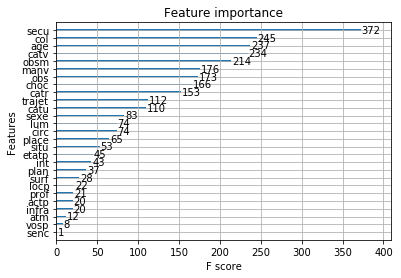

My program took 29.169892072677612  (s) to run


In [86]:
import time
start_time = time.time()
#load data : 
data_without_imputing=pd.read_csv('dataset-without-imputing-2005-2016/data_without_imputing1.csv',encoding='latin-1')

# More feature engineering :
##age :
data_without_imputing['age']=pd.Series(data_without_imputing.an.values - data_without_imputing.an_nais.values)
#choose features to use for classification  : 
#( we delete all spatiale features: lon/lat/dep/com/addresse/agg/voie/v1/v2 ..)
# we delete an/mois/jours ( later we will do feature engineering to creata a variable for the number of the day in the week 
#to see the effet of weekend ...)

col_used =['lum','int', 'atm', 'col', 'catr', 'circ', 'vosp', 'prof', 'plan', 'surf', 'infra', 'situ', 'senc', 'catv',
       'obs', 'obsm', 'choc', 'manv', 'place', 'catu',
       'grav', 'sexe', 'trajet', 'secu', 'locp', 'actp', 'etatp','age']
data_without_imputing=data_without_imputing.loc[:,col_used]

#DataFrame.dtypes for data must be int, float or bool. So we do not perform any changing for dtypes

# split data into target and feature data :
y=data_without_imputing.grav.values  # target column
X=data_without_imputing.loc[:,data_without_imputing.columns!='grav']  # feature data
#required  libraries :
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.metrics import accuracy_score

#split data into train/test data :
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=1)

#fit model on training set

xgboost_model=XGBClassifier(n_jobs=-1,max_depth=3) # n_jobs=-1 to use all threads available
xgboost_model.fit(X_train,y_train)

#evaluate on train set to assist overfitting : 
y_pred_train=xgboost_model.predict(X_train)
accuracy_train = accuracy_score(y_train, y_pred_train)
print("Accuracy on train set : %.2f%%" % (accuracy_train * 100.0))

#predict on test set :
y_pred_test=xgboost_model.predict(X_test)
cm=confusion_matrix(y_test,y_pred_test)
print("Confsuion matrix : \n ",cm)
print('Classification report : \n ',classification_report(y_test,y_pred_test))
accuracy_test = accuracy_score(y_test, y_pred_test)
print("Accuracy on test set : %.2f%%" % (accuracy_test * 100.0))
plot_importance(xgboost_model)
plt.show()
print("My program took", time.time() - start_time, " (s) to run")

Ci dessous les résultats pour xgboost avec imputation stationnaires des valeurs manquantes : (param par défaut pour xgboost)

classification report : 

               precision    recall  f1-score   support

          1       0.67      0.86      0.75     24204
          2       0.57      0.01      0.01      1631
          3       0.47      0.23      0.31     12111
          4       0.56      0.59      0.58     21303

avg / total       0.59      0.61      0.58     59249

Les résultats sont très satisfaisantes pour xgboost sans imputation des valeurs manquantes. Ceci est surtout pour la classe minoritaire tué où on a obtenu une précision de 0.75.

De plus en voyant les accuracy correspondants aux train et test on remarque qu'il n'y a pas d'overfitting. 

A noter que les variables ajoutées via le feature engineering n'aident pas à prédire la variable cible. Ceci a pour intérprétation : la gravité des accidents ne dépend pas du jour de la semaine, ni de la nuit, ni de l'heure de la pointe.


##### En prenant que les variables les plus importantes : 

C:\Users\rlouriz\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\rlouriz\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Accuracy on train set : 61.25%
Confsuion matrix : 
  [[20938     0   487  2779]
 [  405     7   732   487]
 [ 3000     2  2718  6391]
 [ 6971     1  1825 12506]]
Classification report : 
               precision    recall  f1-score   support

          1       0.67      0.87      0.75     24204
          2       0.70      0.00      0.01      1631
          3       0.47      0.22      0.30     12111
          4       0.56      0.59      0.58     21303

avg / total       0.59      0.61      0.58     59249

Accuracy on test set : 61.05%


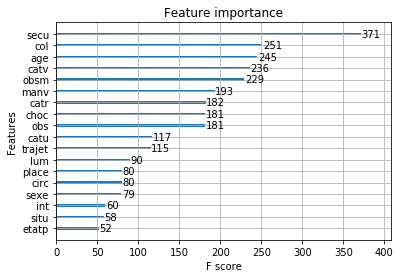

In [85]:
import time
start_time = time.time()
#load data : 
data_without_imputing=pd.read_csv('dataset-without-imputing-2005-2016/data_without_imputing1.csv',encoding='latin-1')

# More feature engineering :
##age :
# let's first create an attribute age :
data_without_imputing.loc[:,['an']]=data_without_imputing.loc[:,['an']]+2000
data_without_imputing['age']=pd.Series(data_without_imputing.an.values - data_without_imputing.an_nais.values)

#choose features to use for classification  : 
#( we delete all spatiale features: lon/lat/dep/com/addresse/agg/voie/v1/v2 ..)
# we delete an/mois/jours ( later we will do feature engineering to creata a variable for the number of the day in the week 
#to see the effet of weekend ...)

col_used =['lum','int', 'col', 'catr', 'circ', 'situ', 'catv',
       'obs', 'obsm', 'choc', 'manv', 'place', 'catu',
       'grav', 'sexe', 'trajet', 'secu', 'etatp','age']
data_without_imputing=data_without_imputing.loc[:,col_used]

#DataFrame.dtypes for data must be int, float or bool. So we do not perform any changing for dtypes

# split data into target and feature data :
y=data_without_imputing.grav.values  # target column
X=data_without_imputing.loc[:,data_without_imputing.columns!='grav']  # feature data
X['age'] = np.log1p(X['age']) # normalize age

#required  libraries :
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.metrics import accuracy_score

#split data into train/test data :
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=1)

#fit model on training set

xgboost_model=XGBClassifier(n_jobs=-1,max_depth=3) # n_jobs=-1 to use all threads available
xgboost_model.fit(X_train,y_train)

#evaluate on train set to assist overfitting : 
y_pred_train=xgboost_model.predict(X_train)
accuracy_train = accuracy_score(y_train, y_pred_train)
print("Accuracy on train set : %.2f%%" % (accuracy_train * 100.0))

#predict on test set :
y_pred_test=xgboost_model.predict(X_test)
cm=confusion_matrix(y_test,y_pred_test)
print("Confsuion matrix : \n ",cm)
print('Classification report : \n ',classification_report(y_test,y_pred_test))
accuracy_test = accuracy_score(y_test, y_pred_test)
print("Accuracy on test set : %.2f%%" % (accuracy_test * 100.0))
plot_importance(xgboost_model)
plt.show()


Les résultats sont satisfaisantes avec peu de variables; ces variables sont les plus importantes pour la détermination de la gravité des accidents.

## Conclusion 

Suite à notre analyse ci-dessous, on opte pour XGBoost pour la modélisation de notre classification Ce choix est justifié par plusieurs raisons :

    1. utilise plusieurs  d'arbre ==> diminue la variance 
    
    2. on peut savoir l'importance des variables
    
    3. le meilleur en terme de performance
    4. cohérent avec plusieurs types de variables ( numériques, catégorielles)

### Grid Search pour xgboost

Ce code nécessite beaucoup de temps pour qu'il soit exécuté. Mais globalement en essayant qlq param on trouve que les meilleurs paramétres sont ceux par défaut.

http://xgboost.readthedocs.io/en/latest/how_to/param_tuning.html : for more detail about tunning xgboost

In [ ]:
#load data :
data_without_imputing=pd.read_csv('data_without_imputing1.csv',encoding='latin-1')
# let's first create an attribute age :
data_without_imputing.loc[:,['an']]=data_without_imputing.loc[:,['an']]+2000
data_without_imputing['age']=pd.Series(data_without_imputing.an.values - data_without_imputing.an_nais.values)
#choose features to use for classification  : 
#( we delete all spatiale features: lon/lat/dep/com/addresse/agg/voie/v1/v2 ..)
# we delete an/mois/jours ( later we will do feature engineering to creata a variable for the number of the day in the week 
#to see the effet of weekend ...)

col_used =['lum','int', 'atm', 'col', 'catr', 'circ', 'vosp', 'prof', 'plan', 'surf', 'infra', 'situ', 'senc', 'catv',
       'obs', 'obsm', 'choc', 'manv', 'place', 'catu',
       'grav', 'sexe', 'trajet', 'secu', 'locp', 'actp', 'etatp', 
       'age']
data_without_imputing=data_without_imputing.loc[:,col_used]

#DataFrame.dtypes for data must be int, float or bool. So we do not perform any changing for dtypes

# split data into target and feature data :
y=data_without_imputing.grav.values  # target column
X=data_without_imputing.loc[:,data_without_imputing.columns!='grav']  # feature data

X['age'] = np.log1p(X['age']) # normalize age

#required  libraries :
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.model_selection import  GridSearchCV
from sklearn.metrics import accuracy_score

#split data into train/test data :
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=1)


#fit model on training set
xgboost_model=XGBClassifier(n_jobs=-1,max_delta_step=1) # n_jobs=-1 to use all threads available

grid_values = {'max_depth': [3,4,5,6,7],'n_estimators':[100,150,200],'subsample':[1,0.8,0.7],'scale_pos_weight':[1,0.7,0.4]}
#metric to optimize over grid parameters: accuracy
grid_clf = GridSearchCV(xgboost_model, param_grid = grid_values)
grid_clf.fit(X_train, y_train)

#print best score for accuracy : 
print(grid_clf.best_score_)
#print best parameters giving the above accuracy : 
print(grid_clf.best_params_)

C:\Users\rlouriz\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\rlouriz\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## Fin choix algorithme